In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from math import sqrt
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
import glob

sns.set_style('white')

In [2]:
filename_2019 = glob.glob('../data/2019/*.csv')
filename_2019

['../data/2019/jmm.csv',
 '../data/2019/jm.csv',
 '../data/2019/egm.csv',
 '../data/2019/lm.csv',
 '../data/2019/cum.csv',
 '../data/2019/hcm.csv',
 '../data/2019/rbm.csv',
 '../data/2019/smm.csv',
 '../data/2019/im.csv',
 '../data/2019/ppm.csv',
 '../data/2019/alm.csv',
 '../data/2019/nim.csv',
 '../data/2019/cfm.csv',
 '../data/2019/tam.csv',
 '../data/2019/pbm.csv',
 '../data/2019/znm.csv',
 '../data/2019/mam.csv',
 '../data/2019/ebm.csv',
 '../data/2019/agm.csv',
 '../data/2019/srm.csv',
 '../data/2019/vm.csv',
 '../data/2019/snm.csv',
 '../data/2019/oim.csv',
 '../data/2019/rum.csv',
 '../data/2019/bum.csv']

In [3]:
df = pd.read_csv(filename_2019[0], index_col=0, encoding='gbk')
df.columns = ['code', 'time', 'open', 'high', 'low', 'close', 'volume', 'turnover', 'open interest']
df.rename_axis("type", axis='index', inplace=True)
df['time'] = pd.to_datetime(df['time'])

df.reset_index(inplace=True)
df

,type,code,time,open,high,low,close,volume,turnover,open interest
0,DC,jm1905,2019-01-02 09:01:00,1171.0,1176.0,1169.0,1172.5,4228.0,297235260.0,212034
1,DC,jm1905,2019-01-02 09:02:00,1172.5,1176.5,1172.5,1174.0,1828.0,128881500.0,211456
2,DC,jm1905,2019-01-02 09:03:00,1174.0,1176.5,1174.0,1175.5,1482.0,104521260.0,211368
3,DC,jm1905,2019-01-02 09:04:00,1175.5,1176.0,1173.0,1174.0,850.0,59894700.0,211380
4,DC,jm1905,2019-01-02 09:05:00,1174.0,1175.0,1174.0,1174.0,590.0,41572980.0,211252
...,...,...,...,...,...,...,...,...,...,...
85015,DC,jm2005,2019-12-31 14:56:00,1163.5,1165.5,1162.5,1165.5,1746.0,121952160.0,155608
85016,DC,jm2005,2019-12-31 14:57:00,1165.0,1165.5,1164.5,1165.5,614.0,42924960.0,155662
85017,DC,jm2005,2019-12-31 14:58:00,1165.0,1166.0,1165.0,1165.0,630.0,44048940.0,155544
85018,DC,jm2005,2019-12-31 14:59:00,1165.5,1166.0,1165.0,1165.5,538.0,37614480.0,155648


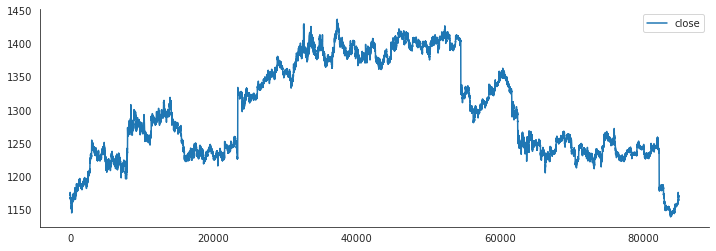

In [4]:
df[['close']].plot(grid=False, figsize=(12,4))
sns.despine()

In [5]:
short_period = [2, 4, 8, 16, 32, 64]
long_period = [8, 16, 32, 64, 128, 256]

df['short_ewm'] = df['close'].ewm(span=short_period[2]).mean()
df['long_ewm'] = df['close'].ewm(span=long_period[2]).mean()

In [6]:
def calculate_hull_moving_average(df, period):

    df['window_t_ewm'] = df['close'].ewm(span=period).mean()
    df['window_half_ewm'] = df['close'].ewm(span=period/2).mean()
    df['diff']=df['window_half_ewm'] * 2 - df['window_t_ewm']
    
    df[f'hma{period}']=df['diff'].ewm(span=int(math.sqrt(period))).mean()
    
    irrelevant_col = ['window_t_ewm', 'window_half_ewm', 'diff']
    df.drop(columns=irrelevant_col, inplace = True)
    
calculate_hull_moving_average(df, short_period[2])
calculate_hull_moving_average(df, long_period[2])

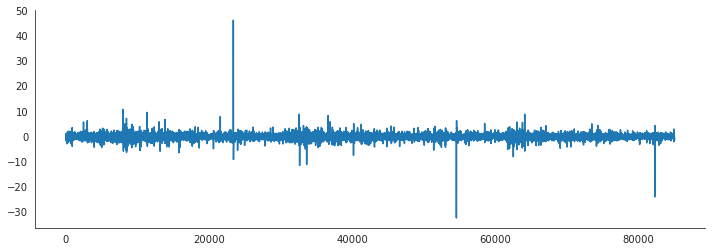

In [7]:
df['short_long_diff'] = df[f'hma{short_period[2]}'] - df[f'hma{long_period[2]}']

short_long_diff_std = df['short_long_diff'].std()

df['momentum'] = df['short_long_diff'] / short_long_diff_std

df['momentum'].plot(grid=False, figsize=(12,4))
sns.despine()

In [8]:
threshold = [0, 0.1, 0.25, 0.5, 0.75, 1, 2]

In [9]:
df['position'] = df['momentum'] > threshold[0]

In [10]:
df['position'].replace({False: 0, True: 1}, inplace=True)
df['position'].value_counts()

1    42791
0    42229
Name: position, dtype: int64

In [11]:
df['returns'] = np.log(df['close']/df['close'].shift(1)).fillna(0)
# Last Minute's Decision and the return
df['strategy'] = df['position'].shift(1).fillna(0) * df['returns']

<AxesSubplot:>

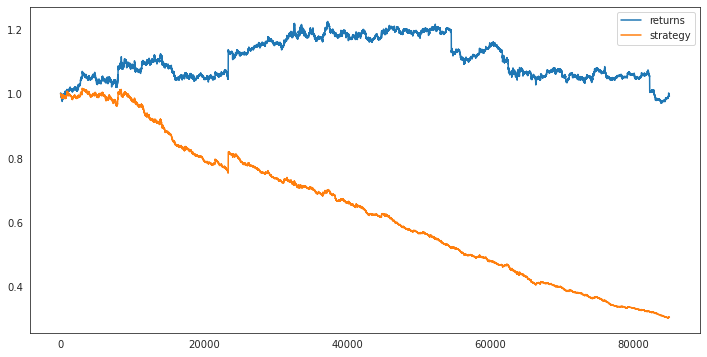

In [12]:
df[['returns','strategy']].cumsum().apply(np.exp).plot(figsize=(12, 6))

In [13]:
sum_logreturn = df[df['position'] == 1]['strategy'].sum()

In [14]:
sum_return = np.exp(sum_logreturn) - 1
sum_return

1.7313745592585534

In [15]:
sharpe = (np.exp(df[df['position'] == 1]['strategy']).mean() - 1) / np.exp(df[df['position'] == 1]['strategy']).std() * sqrt(252)

In [16]:
sharpe

0.5047016308348137

In [17]:
def calculate_momentum(data, short_period, long_period, hma=True):
    if (hma):
        calculate_hull_moving_average(data, short_period)
        calculate_hull_moving_average(data, long_period)
        data['short_long_diff'] = data[f'hma{short_period}'] - data[f'hma{long_period}']
        short_long_diff_std = data['short_long_diff'].std()
        data['momentum'] = data['short_long_diff'] / short_long_diff_std
        
        used_col = ['short_long_diff', f'hma{short_period}', f'hma{long_period}']
        data.drop(columns=used_col, inplace = True)
        
    else:
        data['short_ewm'] = data['close'].ewm(span=short_period).mean()
        data['long_ewm'] = data['close'].ewm(span=long_period).mean()
        data['short_long_diff'] = data['short_ewm'] - data['long_ewm']
        short_long_diff_std = data['short_long_diff'].std()
        data['momentum'] = data['short_long_diff'] / short_long_diff_std
        
        used_col = ['short_long_diff', data['short_ewm'], data['short_ewm']]
        data.drop(columns=used_col, inplace = True)

In [18]:
def calculate_return_from_momentum(data, threshold=1):
    data['position'] = data['momentum'] > threshold
    data['position'].replace({False: 0, True: 1}, inplace=True)
    
    # Last Minute's Decision and the return
    
    data['returns'] = np.log(data['close']/data['close'].shift(1)).fillna(0)
    data['strategy'] = data['position'].shift(1) * data['returns']
    
    # Calculate sum return
    sum_logreturn = data['strategy'].sum()
    sum_return = np.exp(sum_logreturn) - 1
    
    # Calculate Sharpe
    sharpe = (np.exp(data['strategy']).mean() - 1) / np.exp(data['strategy']).std() * sqrt(252)
    
    return sum_return, sharpe

焦煤主力（JMM），表格Index为均线Window长度（short-long），Column为建仓Threshold

In [19]:
data = pd.read_csv(filename_2019[0], index_col=0, encoding='gbk')
# data = pd.read_csv('../data/2019/agm.csv', index_col=0, encoding='gbk')

data.columns = ['code', 'time', 'open', 'high', 'low', 'close', 'volume', 'turnover', 'open interest']
data.rename_axis("type", axis='index', inplace=True)
data['time'] = pd.to_datetime(data['time'])

data.reset_index(inplace=True)

In [20]:
returns = []
sharpes = []
for i in range(len(short_period)):
    calculate_momentum(data, short_period[i], long_period[i])
    current_window_returns = []
    current_window_sharpes = []
    for j in range(len(threshold)):
        sum_return, sharpe = calculate_return_from_momentum(data, threshold[j])
        current_window_returns.append(sum_return)
        current_window_sharpes.append(sharpe)
    returns.append(current_window_returns)
    sharpes.append(current_window_sharpes)

In [21]:
# returns
returns_df = pd.DataFrame.from_records(returns, index =['2-8','4-16','8-32','16-64', '32-128', '64-256'])
returns_df.columns = threshold
print('Sum Return')
returns_df

Sum Return


,0.00,0.10,0.25,0.50,0.75,1.00,2.00
2-8,-0.929930,-0.928225,-0.907525,-0.831866,-0.723436,-0.625120,-0.247446
4-16,-0.821882,-0.807602,-0.795515,-0.737519,-0.654204,-0.574768,-0.244133
8-32,-0.696338,-0.721909,-0.689853,-0.621278,-0.551578,-0.471075,-0.135068
16-64,-0.480492,-0.487191,-0.433409,-0.309840,-0.222633,-0.278458,-0.075260
32-128,-0.183852,-0.174561,-0.246899,-0.068046,-0.080774,-0.022588,-0.071574
64-256,-0.084712,-0.167279,-0.150402,-0.153236,-0.141071,-0.108440,-0.051138


In [22]:
# sharpes
sharpes_df = pd.DataFrame.from_records(sharpes, index =['2-8','4-16','8-32','16-64', '32-128', '64-256'])
sharpes_df.columns = threshold
print('Sharpe')
sharpes_df

Sharpe


,0.00,0.10,0.25,0.50,0.75,1.00,2.00
2-8,-0.844447,-0.865631,-0.822679,-0.707703,-0.554926,-0.654148,-0.310672
4-16,-0.646140,-0.650968,-0.686513,-0.676724,-0.619739,-0.580376,-0.335684
8-32,-0.391843,-0.514163,-0.509401,-0.486844,-0.471889,-0.433017,-0.170657
16-64,-0.202526,-0.214126,-0.204685,-0.146221,-0.108467,-0.230520,-0.097945
32-128,-0.059101,-0.057763,-0.093729,-0.025041,-0.034449,-0.008162,-0.097589
64-256,-0.022829,-0.063210,-0.060854,-0.081825,-0.090309,-0.083008,-0.073138
